# Auxiliary tutorial 3: Dimensionality Reduction (PCA and tSNE)

(c) 2017 Heidi Klumpe and Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained therein is licensed under an [MIT license](https://opensource.org/licenses/MIT). Some code from the scikit-learn tutorial are [BSD licensed](https://opensource.org/licenses/BSD-3-Clause).

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](aux3_dim_reduction.ipynb).*

In [1]:
import numpy as np
import pandas as pd
from time import time

# Packages to perform dimensionality reduction
import sklearn.datasets
import sklearn.decomposition
import sklearn.manifold

# Packages for plotting
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from matplotlib import offsetbox
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# BE/Bi 103 Utilities from Justin
import bebi103

# Make Matplotlib plots appear inline
%matplotlib inline

import bokeh
bokeh.io.output_notebook()

Loading BokehJS ...

## Why do we want to dimensionally reduce our data?

Biological datasets, thanks to technological advances and the suffix "-omics," are high-dimensional. We can record information about every gene, protein, or brain voxel, but then would like to isolate the most descriptive (or maybe predictive) features of those measurements. Ideally, we could remove apparent redundancies or unimportant features, and so be able to focus on the underlying structure that remains. For this reason, we often want to reduce the dimensionality of the data, i.e. summarize it with a smaller number of features.

When we dimensionally reduce our data, we want to answer two questions:
* **How similar or different are a set of observations?**
* **What drives those differences?**

## Dimensional reduction by guessing.

Imagine the following datasets:
* Hand-drawn digits 1 and 5
* Images of different faces
* RNA-Seq of malignant and benign cancer biopsies
* [Neuron firing patterns for people looking at different faces](https://www.ncbi.nlm.nih.gov/pubmed/28575666)

For each dataset, answer the following questions.
1. What are the **observations**?
2. What are the **features**?
3. Propose some _unuseful_ dimensionality reductions.
4. Propose useful combinations of features that might summarize differences between observations.
5. Sketch what the reduced data might look like.
6. What information was lost in your reduction (i.e. what differences between observations are you neglecting)?

(_Hint_: Here are sample answers for hand-drawn digits.
1. The observations are different drawn digits.
2. The features are the intensities of each pixel.
3. We could just consider the inner 5x5 square of pixels; this reduces the dimensions to just 25!
4. We could look at _overall intensity_ v. _symmetry_. We expect 5 to be higher in intensity, but low in symmetry, whereas most 1s are low in intensity, but high in symmetry. We might also imagine functions that detect horizontal bars and curves. 5 would be high horizontal bars and in curves. Most (but not all) 1s would be low in both horizontal bars and curves.
6. There are many different ways to stylize a 1, but our dimensionality reduction will overlook these finer distinctions.)

So, **in the case where we have a lot of intuition about the data, it is possible to guess what combinations of features would be useful for dimensional reduction.** But what about when you don't have that intuition?

## PCA: the most interesting feature is the most variable feature.

For principal component analysis (PCA), this is how we might answer our dimensionality reduction questions:
* **How similar or different are a set of observations?**  
Similar observations are close together in high-dimensional space, but dissimilar observations (e.g. malignant v. benign) will be far apart in high-dimensional space. In fact, those observations that are most far apart are the most interesting differences, since they generate the majority of the spread in the data.
* **What drives those differences?**  
There is some linear combination of the features that generates the most spatial variability, and we'll accept this as the best answer for what drives the differences in the data.

#### Getting a visual feel for maximum variance.

Using these [interactive plots](http://setosa.io/ev/principal-component-analysis/) showing PCA for 2D data, answer the following questions.

1. In your own words, where does $PC1$ seem to fall in the cloud of datapoints?
2. For many manipulations of the dataset, list these by order of decreasing variance: $x$, $y$, $PC1$, $PC2$.
3. What is the relationship between the error (distance from the data point to PC1) and the variance (spread between points in PC1)?
4. What is the covariance matrix for the data plotted in PC1 and PC2? How does it relate to the covariance matrix of the original dataset?

(If you get stuck, try reading [this explanation](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579#140579) or [this tutorial](https://deeplearning4j.org/eigenvector#principal).)

#### Maximum variance is closely related to the shape (or spread) of the data in high-dimensional space.

As we learned above, the dimension of maximum variance (at least in 2D) corresponded to the direction in which the data seemed most stretched. But how do you find those stretched directions at higher dimensions that are impossible to visualize?

The *covariance matrix* of the data serves as a useful summary of the shape of the dataset. Eigendecomposition of the shape (**covariance matrix**) reveals the directions in which the data are stretched (**eigenvectors**) and how much they are stretched by (**eigenvalues**). So, by taking the eigenvectors with the highest eigenvalues, we specify the directions in which the data are most spread (i.e. most variable).

As a simple exercise, sketch a datsaset with covariance matrix, $\boldsymbol{\sigma}$:

\begin{bmatrix}
1 & 0 \\
0 & 5 \\
\end{bmatrix}

(It will probably look like a potato, balanced on its end.) Compute the eigenvalues, such that $\boldsymbol{\sigma}\textbf{v} = \lambda \textbf{v}$. $\textbf{v}$ can have two elements, $\alpha$ and $\beta$. In which direction are the data most stretched? How would the data look after being transformed by the two resulting eigenvectors?

In formal derivations, [it can be shown](https://en.wikipedia.org/wiki/Principal_component_analysis#First_component) that the transformation of the data that generates the maximal variance is given by the eigenvector with the highest eigenvalue, as computed for the covariance matrix. Most of the available algorithms to do PCA use [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) instead of eigendecomposition for computational efficiency.

### Performing PCA in Python

This [blog post](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html) by Sebastian Raschka provides a clean and useful overview of our approach to PCA. This is what we will implement in the following lines to reduce our data to $k$ dimensions:

1. Standardize the data. (To make quantitative comparisons of variance, we want to be sure each measurement varies to a similar extent; more on this later.)
2. Compute the covariance matrix and use eigenvalue decomposition to obtain the eigenvectors and eigenvalues.
3. Select the $k$ largest eigenvalues and their associated eigenvectors.
4. Transform the data into a $k$ dimensional subspace using those $k$ eigenvectors.

Let's give it a try!

#### Our dataset: iris measurements

We will use one of the most famous datasets available online. This data set, collected by Edgar Anderson and popularized by the one and only [Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher), contains the petal and sepal length and width in three different species of Iris (*Iris setosa*, *Iris virginica* and *Iris versicolor*). 

This data set is popular enough to have its own [Wikipedia entry](https://en.wikipedia.org/wiki/Iris_flower_data_set), and you can import it with [seaborn](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.pairplot.html?highlight=iris), [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html), or even pandas using

    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
    df = pd.read_csv(filepath_or_buffer=url, header=None, sep=',')

For this tutorial, we will import it using `scikit-learn` and transform it into a tidy data frame.

In [2]:
# Import the Iris dataset and convert it into a Pandas DataFrame
iris = sklearn.datasets.load_iris()

# Uncomment if you want to print the dataset description
# print(iris.DESCR)

# Make a DataFrame with a species column
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['species'] = iris.target_names[iris.target]

# Take a look at df_iris
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


We can plot pairwise comparisons using Seaborn's `pairplot()` function to see if there are striking correlations between any two features of the iris data set. If any two features are highly correlated, we may assume we can summarize those two features with a single axis (i.e. "new" feature) that includes both.

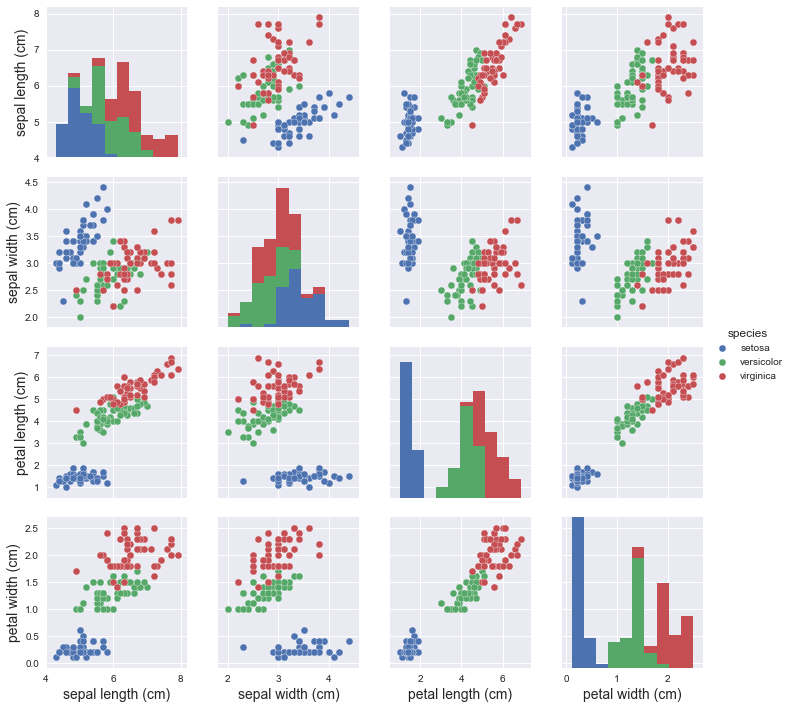

In [3]:
# Plot pairwise comparison to explore the data
_ = sns.pairplot(df_iris, hue='species')

Right away from this plot we can notice that *versicolor* and *virginica* are more similar to each other than to *setosa*.  There is also a strong correlation between *petal length* and *petal width*. We can use this to explain the concept behind PCA. So, let's focus on these two parameters.

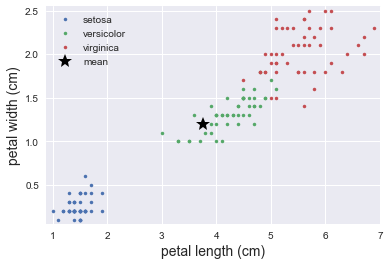

In [4]:
# Compute the mean
m = np.array([df_iris['petal length (cm)'].mean(), 
              df_iris['petal width (cm)'].mean()])

# Plot petal length vs petal width only
for key, group in df_iris.groupby(['species']):
    plt.plot(group['petal length (cm)'], group['petal width (cm)'],
               label=key, marker='.', linestyle='none')

# Add the mean value to the plot
plt.plot(m[0], m[1], marker='*', color='black', markersize=15,
         linestyle='none', label='mean')

plt.legend(loc=0)
plt.margins(0.02)
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)');

Now we are ready to dimensionally reduce our data! Above, we have the full 2-D representation, and the 0-D representation (i.e. the mean).

**1) Standardize the data.**
Because our plot labels have units, we know the two dimensions we're considering are both measured in centimeters, and so have similar scale. But they're different distances from zero! We'll center all measurements at the same point, the mean.

In [5]:
# Substract the mean from the measurements.
df_centered = df_iris.loc[:, ['petal length (cm)', 'petal width (cm)']]
for col in df_centered.columns:
    df_centered[col] -= df_centered[col].mean()

# Take a look
df_centered.head()

,petal length (cm),petal width (cm)
0,-2.358667,-0.998667
1,-2.358667,-0.998667
2,-2.458667,-0.998667
3,-2.258667,-0.998667
4,-2.358667,-0.998667


**2) Compute the covariance matrix and use eigenvalue decomposition to obtain the eigenvectors and eigenvalues.**

In [6]:
cov_mat = np.cov(df_centered.transpose())
print('Covariance matrix \n', cov_mat)

Covariance matrix 
 [[ 3.11317942  1.29638747]
 [ 1.29638747  0.58241432]]


In [7]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors\n', eig_vecs)
print('\nEigenvalues\n', eig_vals)

Eigenvectors
 [[ 0.92154695 -0.38826694]
 [ 0.38826694  0.92154695]]

Eigenvalues
 [ 3.65937449  0.03621925]


We can plot the eigenvectors on top of our data to get a sense of how these principal components can capture the variation in the data.

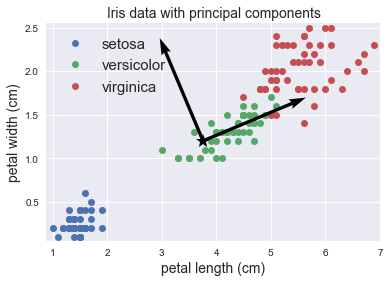

In [8]:
# Plot Petal length vs petal width only
for key, group in df_iris.groupby(['species']):
    plt.plot(group['petal length (cm)'], group['petal width (cm)'],
               label=key, marker='o', linestyle='none')

# Add the mean value to the plot
plt.plot(m[0], m[1], marker='*', color='black', markersize=15)

# Add arrows showing the eigenvectors
plt.quiver([m[0]]*2, [m[1]]*2, eig_vecs[:,1], eig_vecs[:,0], zorder=11, 
           width=0.01, scale=3)
    
# Tidy up plot
plt.legend(loc=0, fontsize=15)
plt.margins(0.02)
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.title('Iris data with principal components');

**3) Select the $k$ largest eigenvalues and their associated eigenvectors.**

In [9]:
# Compute how much variance is explained by each principal component
print("""
PCA 1: {0:.2f}% of the variance
PCA 2:  {1:.2f}% of the variance
""".format(*tuple(eig_vals / np.sum(eig_vals) * 100)))


PCA 1: 99.02% of the variance
PCA 2:  0.98% of the variance



**4) Transform the data into a $k$ dimensional subspace using those $k$ eigenvectors.**

To actually project our data into this new dimension, we have to multiply our data by the so-called projection matrix, which is the fancy name for concatenating the top $k$ eigenvectors together. Then, the dot product of the data with the projection matrix "projects" the data onto our new axis.

Since in this simple example we are projecting into a 1D space, we just have to matrix multiply our data by the eigenvector with the largest corresponding eigenvalue.

In [10]:
# Project data to our 1D space
df_1D = pd.DataFrame(np.dot(df_iris.loc[:,['petal length (cm)',
                                           'petal width (cm)']], eig_vecs[:,0]),
                     columns=['projection'])

# Add back the species column
df_1D['species'] = df_iris['species']
df_1D.head()

,projection,species
0,1.367819,setosa
1,1.367819,setosa
2,1.275664,setosa
3,1.459974,setosa
4,1.367819,setosa


Now we can plot our data in 1D only while maintaining ≈99% percent of the variability in the data!

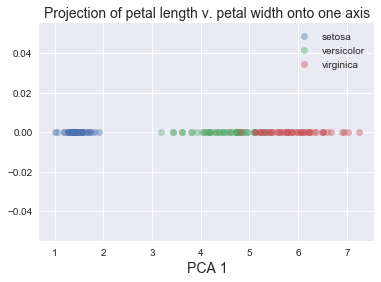

In [11]:
for key, group in df_1D.groupby(['species']):
    plt.plot(group['projection'], np.zeros_like(group['projection']), alpha=0.4, 
             label=key, marker='o', linestyle='none')

plt.margins(0.05)
plt.xlabel('PCA 1')
plt.legend(np.array(['setosa', 'versicolor','virginica']))
plt.title('Projection of petal length v. petal width onto one axis');

### Weaknesses of PCA

#### PCA is not hypothesis testing.

PCA doesn't necessarily provide statistical information or a meaningful metric (what does it mean to think about a linear combination of the features?). But it will make your data easier to look at.

To capture the confusion around the true usefulness of PCA in data analysis, Lior Pachter collected these quotations in his [blog post on PCA](https://liorpachter.wordpress.com/2014/05/26/what-is-principal-component-analysis/) (all emphasis ours):
* "PCA **is not a statistical method** to infer parameters or test hypotheses. Instead, it provides a method to reduce a complex dataset to lower dimension to reveal sometimes hidden, simplified structure that often underlie it."
* "PCA **is a statistical method** routinely used to analyze interrelationships among large numbers of objects."
* PCA is "more useful as **a visualization technique** than as an analytical method."
* PCA is a "mathematical algorithm that reduces the dimensionality of the data while **retaining most of the variation** in the data set."

However, as we might intuit, the eigenvalues and eigenvectors do contain some statistical information. Pachter talks about other approaches to using PCA, which are more interested in the new dimensions onto which the data is projected, rather than the projected data itself. For example, the new dimensions define an "affine subspace closest to a set of points." A 0-D projection is the centroid, or the single point closest to all the data points. A 1-D projection, when we collapse the data onto a single line, that line is the "average line" at a minimal _orthogonal_ distance from all the data.

If that last part sounds a bit like least squares regression, it's because they are related! Pachter's second definition describes how probabilitistic PCA is "a generalization of linear regression in which Gaussian noise is isotropic." We showed in class that a least squares regression is equivalent to maximizing the likelihood, if we assume Gaussian distributed errors in the dependent variable. (Note that this minimizes the _vertical_ distince between the data and the line.) However, for biological processes, we often expect noise in the independent **and** dependent variables. Our "affine subspace," or the dimension onto which we project our data, may describe data better than a linear regression, as it considers both sources of noise (more information [here](https://liorpachter.wordpress.com/2014/05/26/what-is-principal-component-analysis/)).

#### The data may not have similar scales.

PCA is not scale invariant. Imagine if we analyzed the same measurements, but in different units. The shape of the data would change, and so the eigenvector weights would be very different! A dimension varying from 0.1 to 0.2 might be considered much less significant than a dimension varying from 100 to 200. So any implementation of PCA includes a somewhat subjective choice of scale, though [scale-invariant methods](http://uhra.herts.ac.uk/bitstream/handle/2299/715/S56.pdf) do exist.

#### Top PCs may explain a small amount of variance.

In this iris dataset, we were happy to find that most of the variance could be explained by one combination of the two features. But this is by no means given.

Consider the experiment run by Lior Pachter in another [blog post](https://liorpachter.wordpress.com/2014/12/02/the-perfect-human-is-puerto-rican/). He created a "perfect human" *in silico* by setting the alleles at all SNPs so that they are "good" (as specified by [SNPedia](http://www.snpedia.com/)). He then added the "perfect human" to a panel of genotyped individuals from across a variety of populations and performed PCA to reveal the location and population of origin of the individual that was closest to this hypothetical perfect human.

We will use his data and repeat the analysis to find out who the perfect human being is and where is he/she from.  You can download the SNP table, as well as information about the subjects [here](../data/pachter.zip). We will load it into a `DataFrame` where each column heading refers to a SNP and each row is a given subject.  The index of the row is a string representing the subject (including `'perfect'`), and the column headings are the SNP IDs.

In [12]:
# Read the SNP table
df_snp = pd.read_csv('../data/pachter/geno_table.txt', delimiter='\t',
                     index_col='snp_id').transpose()
# PCA needs floats, not integers
df_snp = df_snp.astype(np.float)

df_snp.head()

snp_id,rs307377,rs7366653,rs41307846,rs3753242,rs35082957,rs34154371,rs35426403,rs1143016,rs3890745,rs17472401,...,rs6007897,rs9615362,rs9627183,rs28372448,rs121913039,rs121913037,rs5770917,rs6151429,rs743616,rs2071421
perfect,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HG00096,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
HG00097,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
HG00099,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
HG00100,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


We also have data about each individual, such as where they are from.  The `integrated_call_samples_v3.20130502.ALL.panel` file is also included in the [ZIP file](../data/pachter.zip) containing the data. We will add this to our DataFrame.

In [13]:
# Read the description of each individual
fname = '../data/pachter/integrated_call_samples_v3.20130502.ALL.panel'
df_info = pd.read_csv(fname, delimiter='\t', 
                      index_col=0).dropna(axis=1, how='all')
df_info.head()

,pop,super_pop,gender
sample,,,
HG00096,GBR,EUR,male
HG00097,GBR,EUR,female
HG00099,GBR,EUR,female
HG00100,GBR,EUR,female
HG00101,GBR,EUR,male


In [14]:
# Add to the SNP dataframe the information about gender and super_pop
aux_cols = ['pop', 'super_pop', 'gender']
df_snp[aux_cols] = df_info

# Change the super_pop column for the perfect human being
df_snp.loc['perfect', ['pop', 'super_pop']] = ['Perfect Human']*2

# Take a look at auxiliary columns
df_snp[aux_cols].head()

snp_id,pop,super_pop,gender
perfect,Perfect Human,Perfect Human,NaN
HG00096,GBR,EUR,male
HG00097,GBR,EUR,female
HG00099,GBR,EUR,female
HG00100,GBR,EUR,female


To avoid the problems described above (where different features have vastly different scales, thus over- or underemphasizing their contribution to the overall variance), we will use a **common set of units**.

We will standardize these values such that they all have a common mean and variance (usually set to be zero and one respectively). Though still a somewhat subjective choice, this ensures that variance in each dimension happen on roughly the same scale.

Fortunately, as in almost every case, `scikit-learn` can do the job for us. We will simply use the `StandardScaler` class from the `preprocessing` module of `scikit-learn` to fix this.

In [15]:
# Standardize the data before performing PCA
# We use .drop to remove the gender and super_pop columns to avoid errors.
df_snp_std = sklearn.preprocessing.StandardScaler().fit_transform(
                            df_snp.drop(aux_cols, axis=1))

# Perform the PCA and transform the data
n_components = 5
snp_pca = sklearn.decomposition.PCA(n_components=n_components)

# Project the data into this 2D space
snp_pca.fit(df_snp_std)
df_snp_pca = snp_pca.transform(df_snp_std)

# Convert back to a nice tidy dataframe
df_snp_pca = pd.DataFrame(df_snp_pca, 
                columns=['PC' + str(x) for x in range(1, n_components+1)], 
                index=df_snp.index)

# Add again the gender, pop, and super_pop columns
df_snp_pca[aux_cols] = df_snp[aux_cols]
df_snp_pca.head()

,PC1,PC2,PC3,PC4,PC5,pop,super_pop,gender
perfect,-2.221873,-13.823952,193.949954,26.723158,-2.305449,Perfect Human,Perfect Human,NaN
HG00096,-6.037516,-15.947683,0.534959,-3.384760,-3.550170,GBR,EUR,male
HG00097,-6.310191,-14.804931,1.029816,-13.768378,4.553438,GBR,EUR,female
HG00099,-7.102287,-15.820245,4.378639,-4.107041,-3.095211,GBR,EUR,female
HG00100,-6.006800,-17.297061,0.387674,-4.464557,-2.678060,GBR,EUR,female


Great! Now, we know that plotting our multi-dimensional data in 2-D will give us an idea of which points are similar and dissimilar. So, if we believe genetic fitness is entirely determined by the absence and presence of universally good and bad SNPs, we may be interested in which humans are closest to the "perfect" human created by Lior Pachter. (Shortly after, we may offer our services to Hydra.) We will find this out by plotting all the SNP profiles in 2-D space.

In [16]:
# What pops up on hover?
tooltips = [('gender', '@gender'),
            ('pop', '@pop'),
            ('ID', '@index')]

# Make the hover tool
hover = bokeh.models.HoverTool(tooltips=tooltips)

# Create figure
p = bokeh.plotting.figure(plot_width=650, plot_height=450, x_axis_label='PC1',
                          y_axis_label='PC2')

# Add the hover tool
p.add_tools(hover)

# Define colors in a dictionary to access them with
# the key from the pandas groupby funciton.
keys = df_snp_pca.super_pop.dropna().unique()
color_dict = {k: bokeh.palettes.mpl['Viridis'][5][i] 
                      for i, k in enumerate(sorted(keys))}

for key, group in df_snp_pca.groupby('super_pop'):
    # Specify data source
    source = bokeh.models.ColumnDataSource(group)
    
    # Populate glyphs
    if key == 'Perfect Human':
        p.diamond_cross(x='PC1', y='PC2', size=20, source=source, 
                        color='black', fill_color=None, line_width=2,
                        legend=key)
    else:
        p.circle(x='PC1', y='PC2', size=7, alpha=0.2, source=source,
                 color=color_dict[key], legend=key)

p.legend.background_fill_alpha = 0.25
# Blanched almonds are the best kind of almonds
p.legend.background_fill_color = 'blanchedalmond'
bokeh.io.show(p)

So the closest point to the perfect human being is patient [HG00737](https://catalog.coriell.org/0/Sections/Search/Sample_Detail.aspx?Ref=HG00737&PgId=166) a ***Puerto Rican woman***! (Second most perfect human, a Puerto Rican man named Lin-Manuel Miranda, not shown.)

How confident are we that this plot indicates a Puerto Rican woman is the closest to being perfect? How much of the true varaince of the SNP dataset is captured in this simple 2D projection?

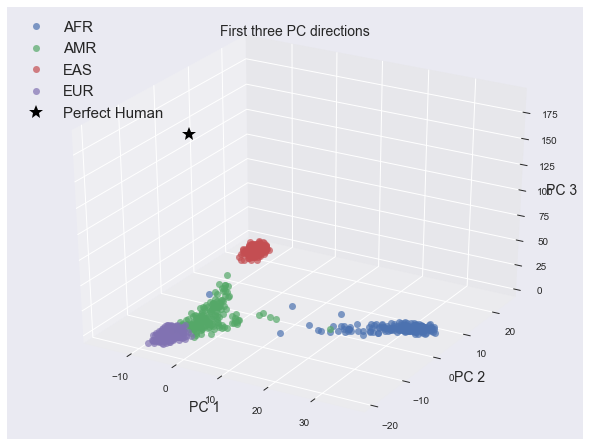

In [17]:
fig = plt.figure(1, figsize=(8, 6))
ax = mpl_toolkits.mplot3d.Axes3D(fig)
for key, group in df_snp_pca.groupby(['super_pop']):
    if key == 'Perfect Human':
        ax.plot(group.PC1, group.PC2, group.PC3, 'k*', markersize=15,
                label=key)
    else:
        ax.plot(group.PC1, group.PC2, group.PC3, 'o', alpha=0.7, label=key)

ax.set_title("First three PC directions")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.legend(loc='upper left', fontsize=15);

Wow! The perfect human is actually... not human. What happened here?

We didn't check how much variance the first two axes explained; for the most part, we picked two dimensions because we publish papers in a two-dimensional format. It seems that there is a *significant* amount of variance explained by the third axis. In fact, it separates the "perfect" human from all other humans.

In [18]:
print('Variance percent explained\n', snp_pca.explained_variance_ratio_)

Variance percent explained
 [ 0.05660433  0.04227824  0.00728842  0.00597724  0.0054038 ]


As some final food for thought: 
1. **What might this result mean about SNP frequencies biologically?** (Perhaps for something with complex dependencies on many hidden variables, it is not surprising that its structure is poorly described by two dimensions, particularly when those two dimensions are just linear combinations of the existing measurements.)

2. **What might this result mean about the shape of the data in higher dimensions?** For the biological reasons described above, the data may be highly nonlinear, which is difficult to capture with PCA. 

Consider a dataset that look like a circle- the 1D representation via PCA would try to preserve the long distance between diametrically opposed points, but overlook close distances between adjacent point as less interesting, higher-order correlations.

Does this seem like the best approach?

## t-SNE: the most interesting features are points very close in high-dimensional space.

For t-distributed stochastic neighbor embedding, this is how we might answer our dimensionality reduction questions:
* **How similar or different are a set of observations?**    
Similar points are very close to each other in high dimensional space, but dissimilar points maybe be somewhat close or a medium distance apart. It's important to preserve nearest neighbors, and treat all other points as equally far away.
* **What drives those differences?**  
We have no idea.

### Linear dimensionality reduction cannot cluster data with non-linear global structure.

Below is an example adapted from the `scikit-learn` documentation on [manifold learning](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py), written by Fabian Pedegrosa, Olivier Grisel, Mathieu Blondel, and Gael Varoquaux. We will compare linear and non-linear dimensionality reduction to create clusters of hand-drawn digits. We can import a dataset of these hand-drawn numbers from the `sklearn` module.

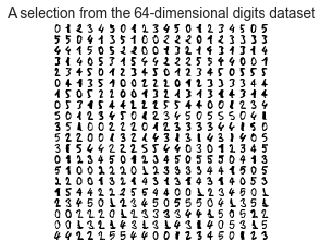

In [19]:
# Load the data from sklearn
digits = sklearn.datasets.load_digits(n_class=6)

# Store the data and targets
digit_images = digits.data
digit_classes = digits.target

# The data are rows of pixel values, and each pixel value is a feature (64 pixels in an 8x8 image).
n_samples, n_features = digit_images.shape

# Take a look at the data
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10*i + 1
    for j in range(n_img_per_row):
        iy = 10*j + 1
        img[ix:ix + 8, iy:iy + 8] = digit_images[i * n_img_per_row + j].reshape((8,8))
        
plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset');

In the [tutorial](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py), they define a function to plot a picture of each number, rather than merely a point. This will be useful for determining the success of clustering.

In [20]:
def plot_embedding(embed, title=None, show_classes=True, show_examples=True):
    # Determine range of values of embedded points
    x_min, x_max = np.min(embed, 0), np.max(embed, 0)
    # Scale all points between 0 and 1
    scaled_embed = (embed - x_min) / (x_max - x_min)
    
    # Instantiate figure
    plt.figure()
    ax = plt.subplot(111)
    
    if show_classes:
        # Color each number differently (shows how we expect data to cluster)
        for i in range(scaled_embed.shape[0]):
            plt.plot(scaled_embed[i,0], scaled_embed[i,1], '.',
                     color = plt.cm.Set1(digit_classes[i]/10))
    else:
        plt.plot(scaled_embed[:,0], scaled_embed[:,1], '.k')
    
    if show_examples:
        if hasattr(offsetbox, 'AnnotationBbox'):
            # Only print thumbnail with matplotlib > 1.0;
            # initialize shown_images array
            shown_images = np.array([[1, 1]])

            # Iterate through the number of digits we imported
            for i in range(digits.data.shape[0]):
                dist = np.sum((scaled_embed[i] - shown_images) **2, 1)
                # Don't put thumbnails too close together
                if np.min(dist) < 4e-3:
                    continue
                # Concatenate the  locations of the images to be plotted
                shown_images = np.r_[shown_images, [scaled_embed[i]]]
                # Define the grayscale image of the number
                imagebox = offsetbox.AnnotationBbox(
                    offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                    scaled_embed[i])
                ax.add_artist(imagebox)
                
    # Remove x and y ticks
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Now, we will use PCA (our linear approach) and t-SNE (our non-linear approach) to reduce this 64-dimensional dataset to 2 dimensions. (We will discuss the t-SNE syntax in more detail later on.) Keep in mind that each "dimension" is the grayscale value of each pixel in the image of the hand-drawn digit. We want to see if the structure of the data (i.e. what we know about which images are 0s, 1s, 2s, etc.) is visible in 2D.

In [21]:
# Time the PCA computation
t0 = time()

# Use singular value decomposition to find eigenvalues and eigenvectors
digit_pca = sklearn.decomposition.TruncatedSVD(n_components=2)

# Transform the data
embed_pca = digit_pca.fit_transform(digit_images)

# Store the time
t_pca = time() - t0

# Print time 
print('PCA took %.3fs.' % t_pca)


# Time the tSNE computation
t0 = time()

# Find the optimal low-dimensional representation with t-SNE
tsne = sklearn.manifold.TSNE(n_components=2, init='pca', random_state=0)
embed_tsne = tsne.fit_transform(digit_images)

# Store the time
t_tsne = time() - t0

# Print time
print('t-SNE took %.3fs.' % t_tsne)

PCA took 0.006s.
t-SNE took 19.026s.


Wow. We can already see that t-SNE takes almost 100 times longer. We can compare the results by plotting the resulting low-dimensional spaces (also called the embedding).

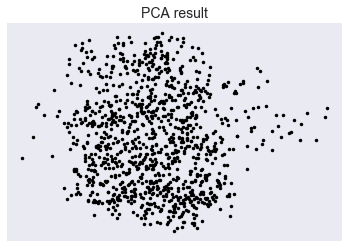

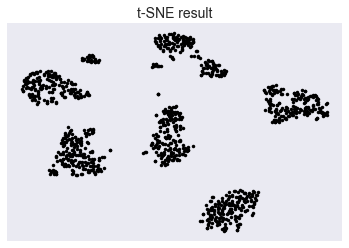

In [22]:
plot_embedding(embed_pca, "PCA result", show_classes=False, show_examples=False)
plot_embedding(embed_tsne, "t-SNE result", show_classes=False, show_examples=False)

Here, we see PCA fails to give us what we were after, which is how different or similar different hand-drawn digits are. Variance is preserved, but the spread of points is just that: a spread of points.

In contrast, t-SNE shows distinct groups. There are roughly 7-8 clusters, depending on how you count. This is intriguing as we know there are 6 hand-drawn digits, ranging from 0 to 5.

To get a better idea of what these maps are trying to communicate, let's color each point by the digit it represents, and overlay them with a few images of those hand-drawn digits.

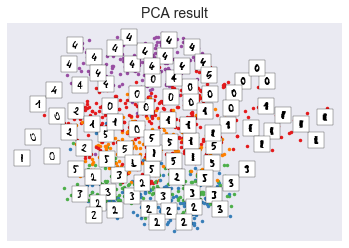

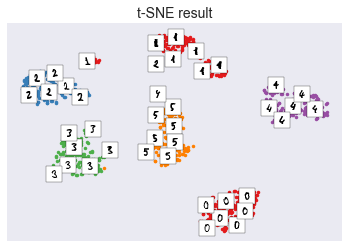

In [23]:
plot_embedding(embed_pca, "PCA result")
plot_embedding(embed_tsne, "t-SNE result")

We see that PCA did actually cluster the different numbers. But without separation between those clusters, we cannot learn much, particularly if we don't know the clusters beforehand!

t-SNE, on the other hand, separates the numbers into discrete clusters quite well, providing more information about the 'structure' of the data. It even distinguishes differences between numbers, and the distances between clusters can be meaningful. 1s separate into those drawn as vertical lines, those with 'hats', and those with a 'hat' and a horizontal bar at the bottom. 1s with hats, that start to resemble 4s, are close to the 4s. 1s with bars at the bottom, which start to resemble 2s, are close to the cluster of 2s.

So why does PCA fail?

### Long-range Euclidean distance, which PCA preserves, is not a good way to quantify (dis)similarity between datapoints for some datasets.

As stated previously, PCA preserves maximal variation in the dimensionally-reduced space, which might be useful if we want to reduce dimensionality but still visualize those large differences.

However, small differences, or strong similarity between points, is often more descriptive than those long-range distances, particularly for a dataset whose global structure is nonlinear. To cartoon this idea, think about a dataset shaped like a Swiss roll.

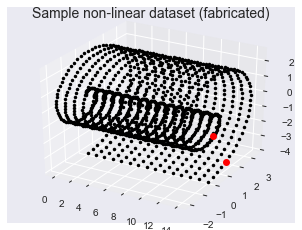

In [24]:
n_points = 100
th = np.linspace(0, 3*np.pi, n_points)
rad = np.linspace(0, 4, n_points)

x = rad * np.sin(th)
y = rad * np.cos(th)

fig = plt.figure(1, figsize=(4,3))
ax = mpl_toolkits.mplot3d.Axes3D(fig)
n_layers = 15;

# Plot our imaginary data
for i in range(n_layers):
    ax.plot(i*np.ones_like(x), x, y,'.k');

# Plot some interesting data points
i = 30;
j = 95;
ax.plot([n_layers-1, n_layers-1], [x[i], x[j]], [y[i], y[j]], 'or')

plt.title('Sample non-linear dataset (fabricated)');

By Euclidean distance, the two red points are fairly close to each other. But judging from the spiraling shape of the data-set, these points are actually much more dissimilar than their 3-D distance would suggest. A better measure of similarity would be to consider primarily nearest neighbors. Essentially, for a non-linear dataset, local linear distance is more meaningful than long-range linear distance.

### SNE: Preserve nearest neighbors in high-dimensional space by making them nearest neighbors in low-dimensional space.

[Nonlinear dimensionality reductions](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction) seek to preserve these short-range distances, and so, unlike PCA or other linear approaches, is not biased toward preserving long-range distances. Thus, they more robustly cluster similar and dissimilar data points. One such approach is called stochastic neighbor embedding (SNE).

#### Model similarity with conditional probability.

In SNE, the similarity between points $x_j$ and $x_i$ is the conditional probability of picking $x_j$ having selected $x_i$, where the probability of picking a point is Gaussian distributed about $x_i$. (It may help to think of this in analogy to the proposal distribution we used in the MCMC samplers, where you were more likely to pick 'close' steps than 'far' steps.) The probability of selecting a nearby point is fairly high, but the probability of selecting any point significantly farther than $\sigma_i$, whether it is moderately close or very far away, is vanishingly small. Formally, this is written as: 

\begin{align}
\\ p_{j|i} = \frac{\mathrm{exp}\left( -\| x_i - x_j \|^2 / 2 \sigma_i^2 \right)}{\sum_{k \neq i}\mathrm{exp}\left( -\| x_i - x_k \|^2 / 2 \sigma_i^2 \right)}
\end{align}

To preserve these nearest neighbors, we need a new distribution of points $\{y_1, ..., y_n\}$ that have similar conditional probabilities. Two points that were likely to be selected together in high-dimensional space ($x_i$ and $x_j$) must also be likely to be selected together in low-dimensional space ($y_i$ and $y_j$). We can also compute the conditional probabilities for points in low-dimensional space*:

\begin{align}
\\ q_{j|i} = \frac{\mathrm{exp}\left( -\| y_i - y_j \|^2 \right)}{\sum_{k \neq i}\mathrm{exp}\left( -\| y_i - y_k \|^2\right)}
\end{align}

#### Iterate to find an embedding $\{y_1, ..., y_n\}$ where the conditional probabilities of high and low dimensional space are most similar.

To determine the goodness of our embedding $\{y_1, ..., y_n\}$, we need a way to quantify how well $q_{j|i}$ captures $p_{j|i}$, or how close in the low-dimensional space are nearest neighbors from high-dimensional space. Such a measure already exists in information theory! 

The **[Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)** (KL divergence), developed in the 1950s, measures the difference between a true probability distribution (here, $p$) and an approximation (here, $q$). More specifically, it measures the information gained when you update a prior $q$ with full posterior probability distribution $p$. If $q$ approximates $p$ well, not much additional information is gained by considering $p$ rather than $q$. Therefore, SNE algorithms seek a low-dimensional distribution of points that minimizes the KL divergence. It is defined as:

\begin{align}
\\ C = \sum_i KL (P_i \| Q_i) = \sum_i \sum_j p_{j|i} \log \frac{p_{j|i}}{q_{j|i}}
\end{align}

We know $p_{j|i}$ is constant, because the high-dimensional map is fixed. $q_{j|i}$ can be high or low, depending on where points $y_i$ and $y_j$ are placed. We see there is a large penalty if $p_{j|i}$ is large, but $x_{j|i}$ is small. Conversely, if $p_{j|i}$ is small, any $x_{j|i}$ will have similarly small penalties. Stated differently, points close in high-dimensional space must stay close, and points that are distant in high-dimensional space can be placed just about anywhere.

To arrive at the final map, start with a random embedding $\{y_1, ..., y_n\}$. Then, use the gradient of the cost function (i.e. $C = \sum_i KL (P_i \| Q_i)$) to optimize the arrangement of points in low-dimensional space. The gradient has the form:

\begin{align}
\\ \frac{\partial C}{\partial y_i} = 2 \sum_j (p_{j|i} - q_{j|i} + p_{i|j} - q_{i|j}) (y_i - y_j)
\end{align}

In his [description](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf), Laurens van der Maaten, the creator of t-SNE, considers this equation like a spring. All points $y_j$ exert some force on $y_i$ in the direction $(y_i - y_j)$ with force $(p_{j|i} - q_{j|i} + p_{i|j} - q_{i|j})$. We can think of $y_i$ being attracted and repulsed by adjacent points until it arrives at an optimal location.

#### Problems with SNE: computationally intensive and prone to "crowding."

Optimizing the cost function described above can require careful fine-tuning. This makes SNE time-consuming. However, there is a more significant problem.

Consider a sphere, where all points are equidistant from the center. We might represent the nearest neighbors as a circle in 2D. But where would you put all the points? In 3D, the points are spread over $4 \pi r^2$, but in 2D must spread over $2 \pi r$. There is much less 'volume' in low-dimensional space, which results in crowding. This problem grows with dimensions, as the volume to spread points of a 10 dimensional cube goes like $r^9$.

If there is not enough room for the points in low-dimensional space, they will tend to spread. However, SNE strongly penalizes pushing points farther apart than they need to be. The summed attractive force of its nearby neighbors will "crush" all the points to the origin, which is not a useful visualization.**

### t-SNE: Compensate for mistmatched dimensionalities with mismatched tails.

We've seen that representing high-dimensional data in low-dimensional space will push the embedded points $\{y_1, ..., y_n\}$ farther apart, which is heavily penalized by the light-tailed Gaussian for $q_{j|i}$. However, we could define a different probability distribution for low-dimensional space that considers these farther distances as still relatively probable! Van der Maaten chose the heavy-tailed Student t-distribution with 1 degree of freedom (which is the same as a Cauchy distribution). Thus, the method was named **t-distributed Stochastic Neighbor Embedding**. 

Now, $q_{j|i}$ has the form:

\begin{align}
\\ q_{j|i} = \frac{\left(1 +\| y_i - y_j \|^2 \right)^{-1}}{\sum_{k \neq i} \left(1 +\| y_i - y_k \|^2 \right)^{-1}}
\end{align}

This allows an embedded point to be moderately far from its neighbors without generating an attractive force between it and all the moderately distant dissimilar points. The resulting cost function ($C = KD(P\|Q)$) still has the desired property of pushing apart embedded points that are moderate to far apart in high-dimensional space, as well as pushing together points which are close in high-dimensional space. The magnitudes of these forces are also much more reasonable than in SNE (e.g. do not increase as embedded points get farther apart from each other; see [Figure 1](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf) in the original t-SNE paper).

**Aside about speed:** Using a Cauchy distribution is faster than a Gaussian, as exponentials require slightly longer to compute. However, t-SNE is also faster because it uses a symmetric (with respect to $i$ and $j$) form of the Kullback-Leibler distribution that yields a simplified form of the gradient.

### Applying t-SNE to a biological dataset: SNP data and the "perfect" human

We used PCA to replicate Lior Pachter's [satirical experiment](https://liorpachter.wordpress.com/2014/12/02/the-perfect-human-is-puerto-rican/) using 2D visualizations of SNP data to find the most nearly perfect human. The previous [PCA tutorial](http://bebi103.caltech.edu/2016/tutorials/aux4_pca.html) discussed the logical difficulties of assigning human fitness to arbitrarily "good" SNPs, as well as the assumption that the "best" human would be one that was closest to the perfect human in a 2D space. However, PCA was an interesting way to look at the structure of the SNP data, and see how it failed to describe such an intrinsically high-dimensional data-set. We required a third principal component to visualize how the 'perfect human' actually had very little in common with any of the other humans represented in the dataset.

Perhaps t-SNE can generate a more successful 2D rendering that shows how dissimilar the 'perfect' human is from other empirically-observed humans?

In [25]:
# Read the SNP table
df_snp = pd.read_csv('../data/pachter/geno_table.txt', delimiter='\t',
                     index_col='snp_id').transpose()
# Convert data to floats
df_snp = df_snp.astype(np.float)

# Take a look at data
df_snp.head()

snp_id,rs307377,rs7366653,rs41307846,rs3753242,rs35082957,rs34154371,rs35426403,rs1143016,rs3890745,rs17472401,...,rs6007897,rs9615362,rs9627183,rs28372448,rs121913039,rs121913037,rs5770917,rs6151429,rs743616,rs2071421
perfect,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HG00096,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
HG00097,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
HG00099,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
HG00100,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


We will add data about the individuals, such as where they are from, to our `DataFrame`, and call them auxiliary columns.

In [26]:
# Read the description of each individual
fname = '../data/pachter/integrated_call_samples_v3.20130502.ALL.panel'
df_info = pd.read_csv(fname, delimiter='\t', 
                      index_col=0).dropna(axis=1, how='all')

# Add to the SNP dataframe the information about gender and super_pop
aux_cols = ['pop', 'super_pop', 'gender']
df_snp[aux_cols] = df_info

# Change the super_pop column for the perfect human being
df_snp.loc['perfect', ['pop', 'super_pop']] = ['Perfect Human']*2

# Take a look at auxiliary columns
df_snp[aux_cols].head()

snp_id,pop,super_pop,gender
perfect,Perfect Human,Perfect Human,NaN
HG00096,GBR,EUR,male
HG00097,GBR,EUR,female
HG00099,GBR,EUR,female
HG00100,GBR,EUR,female


Now we can perform t-SNE.

In [27]:
# Time the tSNE computation
t0 = time()

# Find the optimal low-dimensional representation with t-SNE
tsne_snp = sklearn.manifold.TSNE(n_components=2, init='pca', random_state=0)
embed_snp = tsne.fit_transform(df_snp.drop(aux_cols, axis=1))

# Store the time
t_tsne = time() - t0
# Print time
print('t-SNE took %.2fs.' % t_tsne)

t-SNE took 29.52s.


Store results in `DataFrame` and plot.

In [28]:
# Convert to DataFrame
df_tsne_snp = pd.DataFrame(embed_snp, 
                           columns=['tsne1','tsne2'],
                           index=df_snp.index)
# Add the meta-data
df_tsne_snp[aux_cols] = df_snp[aux_cols]
df_tsne_snp.head()

,tsne1,tsne2,pop,super_pop,gender
perfect,65.467537,-48.145599,Perfect Human,Perfect Human,NaN
HG00096,1.540562,-23.415249,GBR,EUR,male
HG00097,4.474954,-14.046853,GBR,EUR,female
HG00099,1.528425,-23.372646,GBR,EUR,female
HG00100,-0.694595,-13.951630,GBR,EUR,female


In [31]:
# What pops up on hover?
tooltips = [('gender', '@gender'),
            ('pop', '@pop'),
            ('ID', '@index')]

# Make the hover tool
hover = bokeh.models.HoverTool(tooltips=tooltips)

# Create figure
p = bokeh.plotting.figure(plot_width=650, plot_height=450, 
                          x_axis_label='t-SNE axis 1',
                          y_axis_label='t-SNE axis 2')

# Add the hover tool
p.add_tools(hover)

# Define colors in a dictionary to access them with
# the key from the pandas groupby funciton.
keys = df_tsne_snp.super_pop.dropna().unique()
color_dict = {k: bokeh.palettes.mpl['Viridis'][5][i] 
                      for i, k in enumerate(sorted(keys))}

for key, group in df_tsne_snp.groupby('super_pop'):
    # Specify data source
    source = bokeh.models.ColumnDataSource(group)
    
    # Populate glyphs
    if key == 'Perfect Human':
        p.diamond_cross(x='tsne1', y='tsne2', size=20, source=source, 
                        color='black', fill_color=None, line_width=2,
                        legend=key)
    else:
        p.circle(x='tsne1', y='tsne2', size=7, alpha=0.5, source=source,
                 color=color_dict[key], legend=key)

p.legend.background_fill_alpha = 0.25
p.legend.location = 'center_right'
# Blanched almonds are the best kind of almonds
p.legend.background_fill_color = 'blanchedalmond'
bokeh.io.show(p)

Here we see t-SNE performs slightly better than PCA. Already, our 2D map shows that the perfect human does not fit in any clusters with the other datapoints, which matches the PCA result that the perfect human is not quite human. (Why we didn't request samples from Xavier's School for Gifted Youngsters is beyond me.) However, in case we are interested, the perfect human now appears to be a [woman of African descent from the Southwestern United States](https://catalog.coriell.org/0/Sections/Search/Sample_Detail.aspx?Ref=NA19923&Product=DNA). Apparently, [superpopulation has little to do with geography](http://www.internationalgenome.org/category/population/).

### Weaknesses of t-SNE

* **KL divergence is not convex, so each t-SNE run yields a different result.** Since the cost-function we are optimizing is not convex, a solution is not guaranteed to be a global minimum. Thus, you might have to run t-SNE many times before finding a satisfactory result.

Van der Maaten is careful to note that optimizing a non-convex function will always be preferred (1) if the result is better than the global optimum of another cost function and (2) if it is the most computationally feasible. 

* **t-SNE is a non-parametric.** Because this algorithm only returns the optimal embedded map, we gain no new information about how to classify the data, which dimensions of the dataset are important, or how we might classify a new point not already shown in the map. The main usefulness of this technique is to visualize the data structure.

* **t-SNE cannot visualize data with high intrinsic dimensionality.** By using local Euclidean distance, this approach assumes data are locally linear. It also assumes that the dataset is only _superficially_ high-dimensional. Van der Maaten points out: 

> "[T]he reader should note that it is by definition impossible to fully represent the structure of intrinsically-high dimensional data in two or three dimensions."

* **t-SNE behaves unpredictably if we reduce dimensionality to $d > 3$.** In multi-dimensional Student-t distributions, the majority of the probability distribution is in the tails, which may allow clusters to spread farther apart than would be a useful representation. Van der Maaten recommends increasing the degrees of freedom of the Student-t, which lightens the tails, but does not outline a specific approach.

## References
Informal introduction to t-SNE, by creator. [Google TechTalk](https://www.youtube.com/watch?v=RJVL80Gg3lA).

Formal introduction to t-SNE: L.J.P. van der Maaten and G.E. Hinton. Visualizing High-Dimensional Data Using t-SNE. _Journal of Machine Learning Research_ 9(Nov):2579-2605, 2008.

Using the Barnes-Hut approximation: L.J.P. van der Maaten. Accelerating t-SNE using Tree-Based Algorithms. _Journal of Machine Learning Research_ 15(Oct):3221-3245, 2014.

More hints on running and interpreteing [tSNE plots](https://distill.pub/2016/misread-tsne/).


**Footnotes**  
\*We've taken an arbitrary constant for $\sigma$, which is $\frac{1}{\sqrt{2}}$. Any other choise only results in a rescaled version of the final map.  
\**UNI-SNE tries to fix this problem by introducing a 'background repulsion' that keeps points from being pulled to the origin. However, clusters that separate early in the optimization are thus more likely to stay separate, which may create artificial structure.

### More fun t-SNE notes

* **To fully specify the optimization algorithm:**  

Guesses for the embedded points $\{y_1, ..., y_n\}$ are updated by the following function:

\begin{align}
\\ \mathscr{Y}^{(t)} = \mathscr{Y}^{(t-1)} + \eta \frac{\delta C}{\delta \mathscr{Y}} + \alpha (t) \left[ \mathscr{Y}^{(t-1)} - \mathscr{Y}^{(t-2)} \right]
\end{align}

where $\mathscr{Y}^{(t)}$ is the map of embedded points at iteration $t$, $\eta$ is the learning rate, $C$ is the cost function, and $\alpha(t)$ is the momentum. The `sklearn` implemention of t-SNE has good default kwargs for these values, but it's perhaps worth noting that these must be (somewhat arbitrarily) specified to get reasonable results.

You can also specify $\sigma_i$ for each point. This is chosen such that the "perplexity," a rough measure of the number of nearest neighbors, is constant for all datapoints. This corrects for the fact that some points $x_i$ will be in sparser regions than other points. If $\sigma_i$ is too small, all other points $x_j$ will be so far from $x_i$ that it has no effect on the resulting low-dimensional map. Thus, choosing a good value for $\sigma_i$ allows you to weight all points relatively equally. `sklearn` will do this for us automatically.

* **For large datasets:** 

Computing pairwise distances scales like $O(N^2)$, and can become computationally infeasible for real-world datasets with thousands of data points. It would be easier to instead cluster a subset of the data; however, we lose information about the local density provided by those missing points. Instead, you can represent a clusters of points by their center of mass, multiplied by the number of points in the cluster. Thus, you fully approximate the effect of that dense cluster. These clusters of points are determined by the [Barnes-Hut approximation](https://en.wikipedia.org/wiki/Barnes%E2%80%93Hut_simulation), which has criteria for subdividing the high-dimensional space.

Also, for all the implementations here, `sklearn` first runs PCA on the data to reduce the dimensionality. As an analytical approach, this is much faster, and reduces the size of computations for t-SNE.

* **For optimized iterations:** 

Arbitrarily keeping the embedded points close ("early compression") early in the optimization allows freer movement of clusters past each other. By constrast, multiplying $p_{j|i}$ by 4, when $q_{j|i}$ is bounded between 0 and 1, increases the cost of any embedding that does not move the embedded points very close together. By forcing tighter clusters, this approach ("early exaggeration") causes the low-dimensional maps to become very separated. 